# CODA-database-sandbox

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

#### Date: 11 September 2024

# detect compute platform

In [1]:
import os
import socket
    
def get_platform():
    hostname = socket.gethostname()
    if "gadi" in hostname:  # Adjust this condition to fit your HPC's hostname or unique identifier
        return 'HPC',hostname
    else:
        return 'Laptop',hostname
[platform,hostname] = get_platform()
print('the platform we are working on is '+platform+' with hostname: '+hostname)

the platform we are working on is HPC with hostname: gadi-cpu-bdw-0122.gadi.nci.org.au


### import packages

In [45]:
import xarray as xr
import pandas as pd
import dask.dataframe as dd
import polars as pl
# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34391,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:36255,Total threads: 4
Dashboard: /proxy/36715/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:41351,


2024-10-21 16:02:43,626 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41567'.
2024-10-21 16:02:43,628 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43165'.


In [4]:
if platform == 'HPC':
    data_path = '/g/data/es60/users/thomas_moore/CODA/2005/'
    write_path = '/g/data/es60/users/thomas_moore/CODA/parquet/'
else:
    data_path = '/Users/moo270/data/CARSv2/CODA/'
    write_path = '/Users/moo270/data/CARSv2/CODA/parquet/'

print(f"Using data path: {data_path}")
print(f"Using write path: {write_path}")

Using data path: /g/data/es60/users/thomas_moore/CODA/2005/
Using write path: /g/data/es60/users/thomas_moore/CODA/parquet/


# build PQ from NetCDF

In [ ]:
ds = xr.open_dataset(data_path+ "WOD_CODA_2005_pfl.nc",chunks="auto")

In [ ]:
ds

In [ ]:
ds = ds.set_coords(['WOD_id',
                    'origflagset',
                    'country',
                    'dataset',
                    'Access_no',
                    'dbase_orig',
                    'Project',
                    'WOD_cruise_identifier',
                    'Institute',
                    'Ocean_Vehicle',
                    'Temperature_Instrument',
                    'CODA_id',
                    'Recorder',
                    'Platform',
                    'crs'])

In [ ]:
ds

# make truncated version of ds

In [ ]:
ds_truncated = ds#.isel(cast=slice(0,9000))

In [ ]:
ds_truncated.nbytes/1e9

In [ ]:
%%time
df = ds_truncated[['Temperature',
                   'Temperature_WODflag',
                   'Temperature_origflag',
                   'Salinity',
                   'Salinity_WODflag',
                   'Salinity_origflag',
                   'Oxygen',
                   'Oxygen_WODflag',
                   'Oxygen_origflag',
                   'Chlorophyll',
                   'Chlorophyll_WODflag',
                   'Chlorophyll_origflag'
                  ]].to_dataframe().reset_index()
df

In [ ]:
# Get the memory usage in bytes
size_in_bytes = df.memory_usage(deep=True).sum()

# Convert to gigabytes (GB)
size_in_gb = size_in_bytes / 1e9

print(f"Size of the DataFrame: {size_in_gb} GB")

# Try removing all-column-NaN-rows here? - https://github.com/CARSv2/cars-v2/issues/26

In [ ]:
%%time
df_squeeze = df.dropna(subset=['Temperature',
                   'Temperature_WODflag',
                   'Temperature_origflag',
                   'Salinity',
                   'Salinity_WODflag',
                   'Salinity_origflag',
                   'Oxygen',
                   'Oxygen_WODflag',
                   'Oxygen_origflag',
                   'Chlorophyll',
                   'Chlorophyll_WODflag',
                   'Chlorophyll_origflag'],how='all').reset_index(drop=True)

In [ ]:
df_squeeze

In [ ]:
# Get the memory usage in bytes
size_in_bytes = df_squeeze.memory_usage(deep=True).sum()

# Convert to gigabytes (GB)
size_in_gb = size_in_bytes / 1e9

print(f"Size of the DataFrame: {size_in_gb} GB")

# write this out to PQ

In [ ]:
%%time
# Writing the Pandas DataFrame to a Parquet file
df_squeeze.to_parquet(write_path+'2005_pfl_df_squeeze.pq', engine='pyarrow', index=False)

# load directly with dask

In [5]:
ddf = dd.read_parquet(write_path+'2005_pfl_df.pq')

##### find columns with byte strings and convert ( is this needed when going from ds --> df --> ddf )

# Polars: for single node, smaller-than-memory operations that are faster than `pandas`

In [6]:
polars_df = pl.read_parquet(write_path+"2005_pfl_df_squeeze.pq")
pdf = polars_df

In [7]:
pdf

cast,z_index,Temperature,Temperature_WODflag,Temperature_origflag,Salinity,Salinity_WODflag,Salinity_origflag,Oxygen,Oxygen_WODflag,Oxygen_origflag,Chlorophyll,Chlorophyll_WODflag,Chlorophyll_origflag,WOD_id,time,lat,lon,origflagset,country,dataset,Access_no,Recorder,dbase_orig,Platform,Project,WOD_cruise_identifier,Institute,Ocean_Vehicle,Temperature_Instrument,z,crs,CODA_id
i64,i64,f32,f64,f64,f32,f64,f64,f32,f64,f64,f32,f64,f64,i32,datetime[ns],f32,f32,binary,binary,binary,f64,binary,binary,binary,binary,binary,binary,binary,binary,f32,i32,binary
1,0,27.816999,0.0,1.0,34.938999,0.0,1.0,null,null,null,null,null,null,10405561,2005-01-01 00:42:11.160091648,-13.641,69.829002,"b""ARGO\x20profiling\x20floats""","b""JAPAN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""J-ARGO\x20(JAPAN\x20ARGO)""","b""JP031068""","b""JAPAN\x20AGENCY\x20FOR\x20MARINE-EARTH\x20SCIENCE\x20AND\x20TECHNOLOGY\x20(JAMSTE""...","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",4.473917,-2147483647,"b""WODpfl200501010001"""
1,1,27.745001,0.0,1.0,34.942001,0.0,1.0,null,null,null,null,null,null,10405561,2005-01-01 00:42:11.160091648,-13.641,69.829002,"b""ARGO\x20profiling\x20floats""","b""JAPAN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""J-ARGO\x20(JAPAN\x20ARGO)""","b""JP031068""","b""JAPAN\x20AGENCY\x20FOR\x20MARINE-EARTH\x20SCIENCE\x20AND\x20TECHNOLOGY\x20(JAMSTE""...","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",9.444819,-2147483647,"b""WODpfl200501010001"""
1,2,27.408001,0.0,1.0,34.98,0.0,1.0,null,null,null,null,null,null,10405561,2005-01-01 00:42:11.160091648,-13.641,69.829002,"b""ARGO\x20profiling\x20floats""","b""JAPAN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""J-ARGO\x20(JAPAN\x20ARGO)""","b""JP031068""","b""JAPAN\x20AGENCY\x20FOR\x20MARINE-EARTH\x20SCIENCE\x20AND\x20TECHNOLOGY\x20(JAMSTE""...","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",13.918531,-2147483647,"b""WODpfl200501010001"""
1,3,27.285999,0.0,1.0,34.997002,0.0,1.0,null,null,null,null,null,null,10405561,2005-01-01 00:42:11.160091648,-13.641,69.829002,"b""ARGO\x20profiling\x20floats""","b""JAPAN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""J-ARGO\x20(JAPAN\x20ARGO)""","b""JP031068""","b""JAPAN\x20AGENCY\x20FOR\x20MARINE-EARTH\x20SCIENCE\x20AND\x20TECHNOLOGY\x20(JAMSTE""...","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",18.889204,-2147483647,"b""WODpfl200501010001"""
1,4,27.233,0.0,1.0,35.000999,0.0,1.0,null,null,null,null,null,null,10405561,2005-01-01 00:42:11.160091648,-13.641,69.829002,"b""ARGO\x20profiling\x20floats""","b""JAPAN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""J-ARGO\x20(JAPAN\x20ARGO)""","b""JP031068""","b""JAPAN\x20AGENCY\x20FOR\x20MARINE-EARTH\x20SCIENCE\x20AND\x20TECHNOLOGY\x20(JAMSTE""...","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",24.257399,-2147483647,"b""WODpfl200501010001"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
64100,44,0.474,0.0,1.0,34.070999,0.0,2.0,null,null,null,null,null,null,11898775,2005-12-31 23:00:57.245635584,39.419998,132.580002,"b""ARGO\x20profiling\x20floats""","b""KOREA;\x20REPUBLIC\x20OF""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""""","b""KR009692""","b""KOREAN\x20OCEAN\x20RESEARCH\x20AND\x20DEVELOPMENT\x20INSTITUTE\x20(KORDI)""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",613.075928

# filter

In [8]:
%%time
# Search for rows where 'column_name' matches a condition
filtered_pdf = pdf.filter(pl.col('z') >= 2000)

CPU times: user 30.7 ms, sys: 23.5 ms, total: 54.2 ms
Wall time: 9.43 ms


In [9]:
filtered_pdf

cast,z_index,Temperature,Temperature_WODflag,Temperature_origflag,Salinity,Salinity_WODflag,Salinity_origflag,Oxygen,Oxygen_WODflag,Oxygen_origflag,Chlorophyll,Chlorophyll_WODflag,Chlorophyll_origflag,WOD_id,time,lat,lon,origflagset,country,dataset,Access_no,Recorder,dbase_orig,Platform,Project,WOD_cruise_identifier,Institute,Ocean_Vehicle,Temperature_Instrument,z,crs,CODA_id
i64,i64,f32,f64,f64,f32,f64,f64,f32,f64,f64,f32,f64,f64,i32,datetime[ns],f32,f32,binary,binary,binary,f64,binary,binary,binary,binary,binary,binary,binary,binary,f32,i32,binary
15,1,27.49,1.0,-9.0,35.580002,1.0,-9.0,null,null,null,null,null,null,10405576,2005-01-01 03:17:59.999827968,-13.809,81.542,"b""""","b""UNITED\x20STATES""","b""profiling\x20float""",1959.0,"b""ARGOS\x20communications,\x20sampling\x20on\x20up\x20transit""","b""GTSP\x20Program""","b""PROFILING\x20FLOAT""","b""U.S.\x20ARGO\x20PROJECT""","b""US028807""","b""UNIVERSITY\x20OF\x20WASHINGTON;\x20SEATTLE""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20Sea-Bird\x20Electronics,\x20MODEL\x20UNKNOWN""",3066.0,-2147483647,"b""WODpfl200501010015"""
96,71,4.567,0.0,1.0,35.161015,0.0,1.0,null,null,null,null,null,null,10405654,2005-01-01 14:31:51.960982528,36.483002,-14.506,"b""ARGO\x20profiling\x20floats""","b""SPAIN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""""","b""ES001259""","b""""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",2005.941772,-2147483647,"b""WODpfl200501010096"""
212,55,2.949,0.0,2.0,34.865002,0.0,2.0,null,null,null,null,null,null,10405750,2005-01-02 08:00:57.238769664,-26.886,-26.415001,"b""ARGO\x20profiling\x20floats""","b""GREAT\x20BRITAIN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""ARGO\x20UK""","b""GB011482""","b""""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",2003.782593,-2147483647,"b""WODpfl200501020070"""
653,71,3.753,0.0,1.0,34.991005,0.0,1.0,null,null,null,null,null,null,10406204,2005-01-05 10:30:00,44.233002,-9.64,"b""ARGO\x20profiling\x20floats""","b""SPAIN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""""","b""ES001250""","b""""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",2004.039673,-2147483647,"b""WODpfl200501050062"""
939,0,21.43,1.0,-9.0,37.330002,1.0,-9.0,null,null,null,null,null,null,10406486,2005-01-07 06:28:00.000113664,-16.613001,-116.598999,"b""""","b""UNITED\x20STATES""","b""profiling\x20float""",1970.0,"b""ARGOS\x20communications,\x20sampling\x20on\x20up\x20transit""","b""GTSP\x20Program""","b""PROFILING\x20FLOAT""","b""U.S.\x20ARGO\x20PROJECT""","b""US028886""","b""UNIVERSITY\x20OF\x20WASHINGTON;\x20SEATTLE""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20Sea-Bird\x20Electronics,\x20MODEL\x20UNKNOWN""",3081.0,-2147483647,"b""WODpfl200501070050"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
63133,55,2.821,0.0,2.0,34.794998,0.0,2.0,null,null,null,null,null,null,10624623,2005-12-27 08:12:11.160735744,-29.524,-37.417,"b""ARGO\x20profiling\x20floats""","b""GREAT\x20BRITAIN""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""ARGO\x20UK""","b""GB011473""","b""""","b""APEX\x20(Autonomous\x20Profiling\x20Explorer,\x20Webb\x20Research\x20Corporati""...","b""CTD:\x20TYPE\x20UNKNOWN""",2004.065308,-2147483647,"b""WODpfl200512270056"""
63241,91,3.43,0.0,1.0,null,null,null,null,null,null,null,null,null,10624770,2005-12-28 00:50:38.039874560,48.310001,-14.918,"b""ARGO\x20profiling\x20floats""","b""FRANCE""","b""profiling\x20float""",42682.0,"b""""","b""US\x20GODAE\x20server\x20(Argo)""","b""""","b""CONGAS\x20(CONTINENTAL\

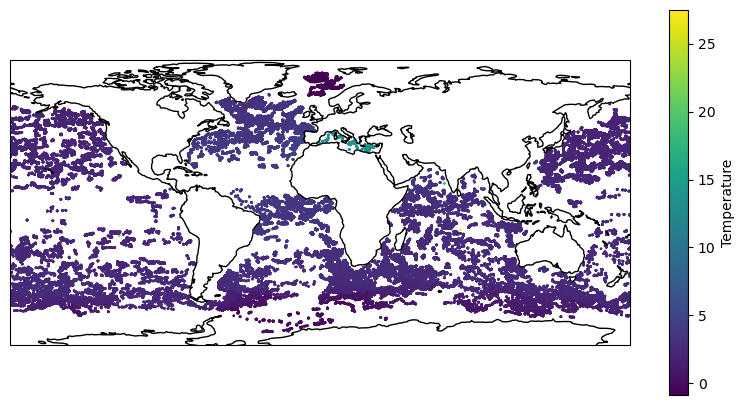

CPU times: user 1.94 s, sys: 441 ms, total: 2.38 s
Wall time: 1.59 s


In [50]:
%%time
# Search for rows where 'column_name' matches a condition
#filtered_pdf = pdf.filter((pl.col('z') >= 50 )& (pl.col('z') <= 150))
filtered_pdf = pdf.filter((pl.col('z') >= 1750 ))

# Step 2: Convert Polars DataFrame to Pandas for compatibility with CartoPy
df = filtered_pdf.to_pandas()

# Step 3: Plotting with CartoPy
# Create a map projection (e.g., PlateCarree for lat/lon)
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features like coastlines, etc.
ax.coastlines()

# Step 4: Plot the lat/lon points with their corresponding values
sc = ax.scatter(df['lon'], df['lat'], c=df['Temperature'], cmap='viridis', s=1, transform=ccrs.PlateCarree())

# Add a colorbar to indicate the values
plt.colorbar(sc, label='Temperature')

# Display the plot
plt.show()

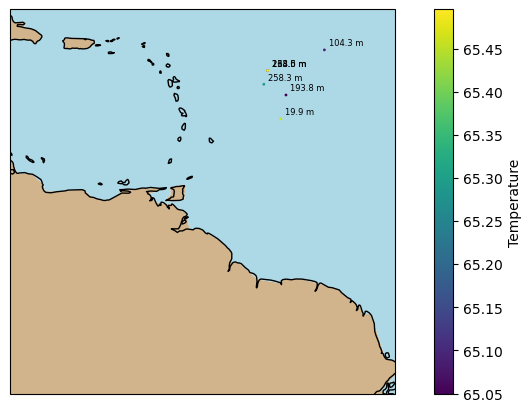

In [49]:
# Step 1: Filter the Polars DataFrame (as in your original code)
# filtered_pdf = pdf.filter((pl.col('z') >= 50 )& (pl.col('z') <= 150))
filtered_pdf = pdf.filter((pl.col('Temperature') >= 65))

# Step 2: Convert Polars DataFrame to Pandas for compatibility with CartoPy
df = filtered_pdf.to_pandas()

# Step 3: Plotting with CartoPy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features like coastlines
ax.coastlines()
# Add the land feature and specify the color
land_feature = cfeature.LAND.with_scale('110m')  # Use '110m' for a low-resolution map (faster plotting)
ax.add_feature(land_feature, facecolor='tan')

# Optionally, add ocean with a different color
ocean_feature = cfeature.OCEAN.with_scale('110m')
ax.add_feature(ocean_feature, facecolor='lightblue')

# Step 4: Plot the lat/lon points with their corresponding values
sc = ax.scatter(df['lon'], df['lat'], c=df['Temperature'], cmap='viridis', s=1, transform=ccrs.PlateCarree())

# Add a colorbar to indicate the values
plt.colorbar(sc, label='Temperature')

# Step 5: Annotate the points with their z values
for i, row in df.iterrows():
    ax.annotate(f"{row['z']:.1f} m", (row['lon'], row['lat']),
                xytext=(3, 3),  # Offset for the text to not overlap with the point
                textcoords='offset points',  # Position the text relative to the point
                fontsize=6,  # Adjust the fontsize
                color='black')  # Color of the text

# Display the plot
ax.set_extent([-70, -50, 0, 20], crs=ccrs.PlateCarree())  # Full world map extent
plt.show()

# list of todo's

- create parquet from a df
- consider utility of turning "metadata" vars into coords
- consider removing NaN's at df step
- consider removing NaN's otherwise



In [ ]:
df.dropna(how='all',column='z')

In [ ]:
%%time
df = ds.to_dataframe()#.reset_index()